In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
import keras

train_path = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/ss1/training'
test_path = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/ss1/test'

train_ds = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(299, 299),
    color_mode='grayscale'
)

tests_ds = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(299, 299),
    color_mode='grayscale'
)

Found 815 files belonging to 2 classes.
Found 192 files belonging to 2 classes.


2024-09-13 02:00:28.048708: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-13 02:00:28.048734: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-13 02:00:28.048741: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-13 02:00:28.048755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 02:00:28.048772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

# Agregar capas de augmentación dentro del modelo
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

# Normalizar los datos dentro del modelo
normalization_layer = Rescaling(1./255)

# Aplicar augmentación y normalización en el flujo del modelo
augmented_train_dataset = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

normalized_train_dataset = augmented_train_dataset.map(
    lambda x, y: (normalization_layer(x), y))

normalized_test_dataset = tests_ds.map(
    lambda x, y: (normalization_layer(x), y))

In [4]:
# Cargar el modelo guardado
model = load_model('weights/model_1.0.0.35_complete.keras', compile=False)

In [5]:
# Iterar sobre las capas del modelo
for layer in model.layers:
    #print(f"Capa: {layer.name}")
    if not layer.get_weights():
        print(f"Capa: {layer.name} -> No se cargaron pesos")
        

Capa: relu1 -> No se cargaron pesos
Capa: relu1.1 -> No se cargaron pesos
Capa: relu1.2 -> No se cargaron pesos
Capa: pool1 -> No se cargaron pesos
Capa: dropout -> No se cargaron pesos
Capa: relu2.1 -> No se cargaron pesos
Capa: relu2.2 -> No se cargaron pesos
Capa: pool2 -> No se cargaron pesos
Capa: dropout_1 -> No se cargaron pesos
Capa: relu3.1 -> No se cargaron pesos
Capa: relu3.2 -> No se cargaron pesos
Capa: pool3 -> No se cargaron pesos
Capa: dropout_2 -> No se cargaron pesos
Capa: relu4 -> No se cargaron pesos
Capa: pool4 -> No se cargaron pesos
Capa: dropout_3 -> No se cargaron pesos
Capa: relu5 -> No se cargaron pesos
Capa: pool5 -> No se cargaron pesos
Capa: dropout_4 -> No se cargaron pesos
Capa: flatten -> No se cargaron pesos
Capa: dropout_5 -> No se cargaron pesos
Capa: fc1_relu -> No se cargaron pesos
Capa: dropout_6 -> No se cargaron pesos
Capa: fc2_relu -> No se cargaron pesos
Capa: dropout_7 -> No se cargaron pesos


In [6]:
# Congelar todas las capas convolucionales (hasta Flatten)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print("Capas convolucionales congeladas.")
for layer in model.layers:
    print(f"Capa: {layer.name} - ¿Entrenable?: {layer.trainable}")

Capas convolucionales congeladas.
Capa: conv1 - ¿Entrenable?: False
Capa: bn1 - ¿Entrenable?: False
Capa: relu1 - ¿Entrenable?: True
Capa: conv1.1 - ¿Entrenable?: False
Capa: bn1.1 - ¿Entrenable?: False
Capa: relu1.1 - ¿Entrenable?: True
Capa: conv1.2 - ¿Entrenable?: False
Capa: bn1.2 - ¿Entrenable?: False
Capa: relu1.2 - ¿Entrenable?: True
Capa: pool1 - ¿Entrenable?: False
Capa: dropout - ¿Entrenable?: True
Capa: conv2.1 - ¿Entrenable?: False
Capa: bn2.1 - ¿Entrenable?: False
Capa: relu2.1 - ¿Entrenable?: True
Capa: conv2.2 - ¿Entrenable?: False
Capa: bn2.2 - ¿Entrenable?: False
Capa: relu2.2 - ¿Entrenable?: True
Capa: pool2 - ¿Entrenable?: False
Capa: dropout_1 - ¿Entrenable?: True
Capa: conv3.1 - ¿Entrenable?: False
Capa: bn3.1 - ¿Entrenable?: False
Capa: relu3.1 - ¿Entrenable?: True
Capa: conv3.2 - ¿Entrenable?: False
Capa: bn3.2 - ¿Entrenable?: False
Capa: relu3.2 - ¿Entrenable?: True
Capa: pool3 - ¿Entrenable?: False
Capa: dropout_2 - ¿Entrenable?: True
Capa: conv4 - ¿Entrenable?

In [7]:
# Compilar el modelo con un optimizador y función de pérdida adecuados
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'recall'])

In [8]:
# Entrenar el modelo congelando las capas convolucionales
history = model.fit(
    normalized_train_dataset,
    validation_data=normalized_test_dataset,
    epochs=20
)

Epoch 1/20


2024-09-13 02:01:08.680880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7214 - loss: 2.0125 - recall: 0.7214 - val_accuracy: 0.7396 - val_loss: 0.9803 - val_recall: 0.7396
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7614 - loss: 0.8844 - recall: 0.7614 - val_accuracy: 0.7396 - val_loss: 0.7401 - val_recall: 0.7396
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7556 - loss: 0.7074 - recall: 0.7556 - val_accuracy: 0.7396 - val_loss: 0.6861 - val_recall: 0.7396
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7398 - loss: 0.7166 - recall: 0.7398 - val_accuracy: 0.7396 - val_loss: 0.7093 - val_recall: 0.7396
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7434 - loss: 0.6977 - recall: 0.7434 - val_accuracy: 0.7396 - val_loss: 0.6717 - val_recall: 0.7396
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7436 - loss: 0.6928 - recall: 0.7436 - val_accuracy: 0.7396 - val_loss: 0.7214 - val_recall: 0.7396
Epoch 7/20
26/26 ━━━

In [19]:
from tensorflow.keras.models import Model

# Obtener la capa flatten
encoder_output = model.get_layer('flatten').output

#Obtener la primera capa para evitar bug -> ValueError: Exception encountered when calling Sequential.call().
model_input = model.get_layer('conv1').input

# Crear modelo solo hata la capa flatten
encoder_model = Model(inputs=model_input, outputs=encoder_output)
# Representación del espacio latente
latent_representations = encoder_model.predict(normalized_train_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step


In [20]:
from sklearn.decomposition import PCA
# Aplicar PCA
pca = PCA(n_components=2)  # O el número de componentes que desees
pca_result = pca.fit_transform(latent_representations)

In [23]:
import numpy as np

# Obtener las etiquetas del dataset en formato numpy
y_train = np.concatenate([y for x, y in train_ds], axis=0)

# Las etiquetas estarán en formato one-hot debido a label_mode='categorical'
# Si prefieres las etiquetas como índices, puedes convertirlas
y_train_indices = np.argmax(y_train, axis=1)

# Imprimir las etiquetas originales y sus índices
print("Etiquetas one-hot:")
print(y_train)
print("Etiquetas como índices:")
print(y_train_indices)

Etiquetas one-hot:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Etiquetas como índices:
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1
 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1

2024-09-13 02:41:45.301776: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


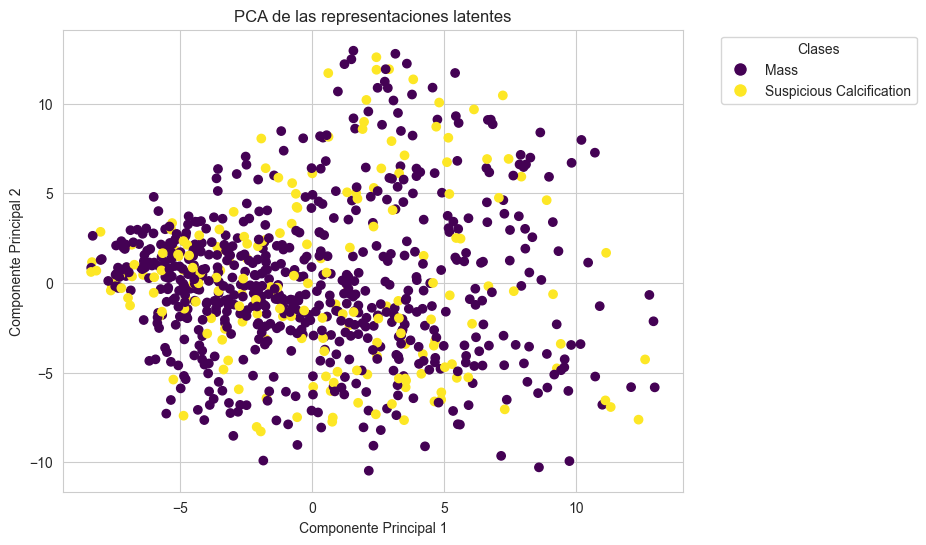

In [27]:
import matplotlib.pyplot as plt

# Lista de nombres de las clases, por ejemplo:
class_names = train_ds.class_names  # Esto extrae los nombres de las clases del dataset

# Crear el gráfico PCA
plt.figure(figsize=(8, 6))

# Colores personalizados para cada clase
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_train_indices, cmap='viridis')

# Crear una leyenda manualmente
# Para esto, creamos una lista de puntos con sus respectivos colores y nombres de clases
handles = []
for i, class_name in enumerate(class_names):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                              markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10))

# Añadir la leyenda
plt.legend(handles=handles, title="Clases", bbox_to_anchor=(1.05, 1), loc='upper left')

# Etiquetas y título
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de las representaciones latentes')

# Mostrar gráfico
plt.show()

Varianza explicada por las primeras 10 componentes:
[0.11510191 0.10152695 0.08606669 0.076591   0.04165348 0.03643652
 0.02543593 0.02115565 0.018486   0.01688042]


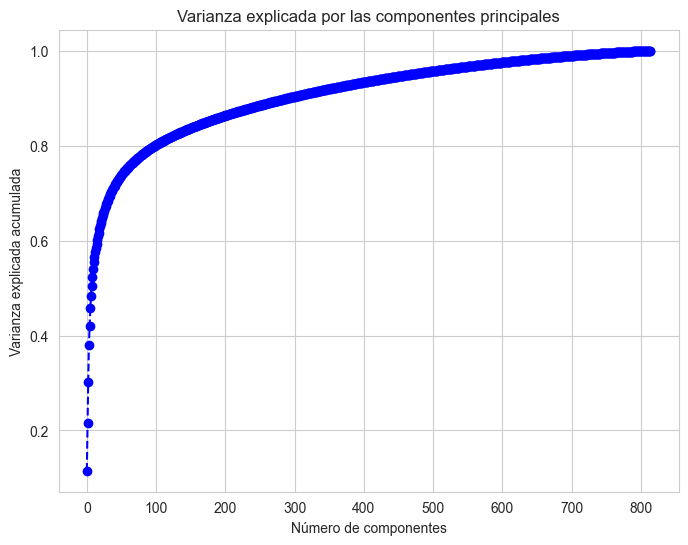

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Aplicar PCA considerando todas las componentes
pca = PCA()  # Si no especificas n_components, calculará todas las componentes
pca_result = pca.fit_transform(latent_representations)

# Obtener la proporción de varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por las primeras componentes
print("Varianza explicada por las primeras 10 componentes:")
print(explained_variance[:10])

# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada por las componentes principales')
plt.grid(True)
plt.show()